# <center>L2 Computational Physics</center>
---
## Week 4: Differential Equations II

In this notebook, you will write a program to study the trajectory of a spherical, iron cannonball in the presence of gravity and drag forces. 

In [1]:
import numpy
from matplotlib import pyplot as plt

In [2]:
# Define all constants to be used in the simulation
r_cb = 0.15  # Radius of cannonball in m
rho_iron = 7874  # Density of iron in kg/m^3
g = 9.81  # Acceleration due to gravity in m/s^2
kappa = 0.47  # Drag coefficient of a sphere
rho_air = 1.23  # Density of air in kg/m^3
v0 = 125.00  # Initial speed in m/s

From this information, calculate the following two variables:

In [3]:
def get_area(r):
    ''' 
    This function returns the cross section area of a sphere of radius r. The returned 
    value is in the squared units of the unit of the radius argument.
    '''
    return numpy.pi*r**2

def get_mass(r):
    ''' 
    This function returns the mass of an iron sphere of radius r. The radius 
    should be given in meter and the return value is in kg.
    '''
    return 4/3*numpy.pi*r**3*rho_iron

area_cb = get_area(r_cb)
mass_cb = get_mass(r_cb)

In [4]:
# these tests are worth one mark
assert numpy.isclose(area_cb, 0.07068583470577035)
assert numpy.isclose(mass_cb, 111.31605249464711)

## The Differential Equations

Create a function `f` which calculates the right-hand side of the differential equation

$$ \frac{d}{dt}\left(\begin{array}{c}x\\y\\v_x \\v_y \end{array}\right) = f(x, y, v_x, v_y, t)$$

such that the differential equation represents the cannonball's motion as it moves through the air. 

- *Your function should accept two arguments:*
    - `r` *- a numpy array representing the cannonball's state, $(x, y, v_{x}, v_{y})$.*
    - `t` *- Time * 
    
- *The drag force experienced by the cannonball is given by $$\vec{F}_{\textrm{d}} = - \frac{1}{2} C_{\textrm{d}} \rho |\vec{v}|^{2} A \widehat{v}~,$$ where $\widehat{v}$ is a unit vector pointing in the direction of the cannonball's instantaneous velocity.*

In [5]:
def f(r, t):
    '''Implements differential equation for cannonball from state vector r and time t'''
    
    # Unpack array of the state
    x, y, vx, vy = r
    
    # these variables should updated in your code to be the derivatives of 
    # the x, y positions and the derivative of the x, y velocities. 
    dx_t, dy_dt, dvx_dt, dvy_dt = 0, 0, 0, 0
    
    dx_dt = vx 
    dy_dt = vy
    dvx_dt = (-kappa*rho_air*area_cb*numpy.sqrt(vx**2+vy**2)*vx)/(2*mass_cb)
    dvy_dt = (-kappa*rho_air*area_cb*numpy.sqrt(vx**2+vy**2)*vy)/(2*mass_cb) - g
    return numpy.array([dx_dt, dy_dt, dvx_dt, dvy_dt])
    

Check your result:

In [6]:
r_test = [0, 0, 88.38834764831843, 88.38834764831843]
assert len(f(r_test, 0))== 4

In [7]:
r_test = [0, 0, 88.38834764831843, 88.38834764831843]
assert numpy.isclose(f(r_test, 0), [ 88.38834765,  88.38834765,  -2.0279283 , -11.8379283 ]).all()

## Solving the Differential Equations

Create the function `solve_euler(state_initial, t1, n_panels)` which solves the differential equations using Euler's method.

- `state_initial` *is a numpy array containing the initial conditions $(x_{0}, y_{0}, v_{x0}, v_{y0})$*
- *When working with a numpy array, you can use the same commands as those used for single variables - for instance,* `state += f(state, t)`.
- *This function should record all state values at each timepoint in the variable `history` and return it. This will be similar to last week, only this time you will have to populate a 2D array.* 


In [8]:
def solve_euler(state_initial, t1, n_steps):
    '''Solves ODE using Euler's method from state_initial to end time t1 using n_panels panels'''
    # Define array for trajectory history
    history = numpy.empty((n_steps+1,4))  # Number of columns is equal to number of variables to solve for (4)
    history[0] = state_initial
    # you should now populate the history array
    dt = t1/n_steps
    for i in range (0, n_steps):
        history[i+1] = history[i]+dt*f(history[i],dt*(i))
        
    return history


Test your solution:

In [9]:
# this test is worth 4 marks
r_test = [0, 0, 88.38834764831843, 88.38834764831843]
assert numpy.isclose(solve_euler(r_test, 25.0, 10), numpy.array(
    [[   0.        ,    0.        ,   88.38834765,   88.38834765],
     [ 220.97086912,  220.97086912,   83.3185269 ,   58.7935269 ],
     [ 429.26718637,  367.95468637,   79.41984538,   31.51743125],
     [ 627.81679983,  446.7482645 ,   76.30595276,    5.75669607],
     [ 818.58168171,  461.14000469,   73.62655732,  -18.97044366],
     [1002.64807501,  413.71389553,   71.05785323,  -42.83359748],
     [1180.2927081 ,  306.62990184,   68.35253688,  -65.72783569],
     [1351.1740503 ,  142.31031262,   65.37829955,  -87.3928075 ],
     [1514.61979917,  -76.17170612,   62.10406078, -107.54105068],
     [1669.87995113, -345.02433282,   58.56508321, -125.93786257],
     [1816.29265915, -659.86898925,   54.83262575, -142.43661744]])).all()

## Finding the range

To find the range of the projectile we will look for the $x$ coordinate when the trajectory crosses the $y=0$ line. In most cases that point will not be one of the steps but will be between two steps. We will use a linear approximation to determine this point given the last point with a positive $y$ value and the first point with a negative $y$ value. Implement the function `find_zero_linear` that takes as argument the two values of $x$ `x1` and `x2` and the heights `y1` and `y2` and returns the value of $x$ at which the line between $(x_1,y_1)$ and $x_2,y_2$ crosses the $y=0$ line.  

In [10]:
def find_zero_linear(x1, x2, y1, y2):
    if y1*y2 > 0:
        print("I expect y1 and y2 to have opposite signs!")
    else:
        return x1-y1*((x1-x2)/(y1-y2))

In [11]:
# these tests are worth 2 marks
assert numpy.isclose(find_zero_linear(-1,1,3,-3),0.0)
assert numpy.isclose(find_zero_linear(-1,1,1,-3), -0.5)

Given the function above we can define a function to determine the range. (Don't modify it!)

In [12]:
def find_range(history):
    all_xs = history[:,0]
    all_ys = history[:,1]
    negatives = numpy.argwhere(all_ys<0)
    if len(negatives) == 0 :
        print ("The projectile did not touch down! Returning the last known location")
        return all_xs[-1]
    (index,) = negatives[0]
    y1, y2 = all_ys[index-1], all_ys[index]
    x1, x2 = all_xs[index -1], all_xs[index]
    return find_zero_linear(x1,x2,y1,y2)

In [13]:
r_test = [0, 0, 88.38834764831843, 88.38834764831843]
h = solve_euler(r_test, 25.0, 10000)
assert numpy.isclose(find_range(h),1306.2541)

## Plotting task

Create a plot to show the trajectories for different values of the initial angle. Use the same velocity $v0=125\rm{m/s}$ for all angles. The plot should have axis labels and a title. [4 marks]


Text(0.5,1,'graph of horizontal against vertical distance travelled for various initial angles')

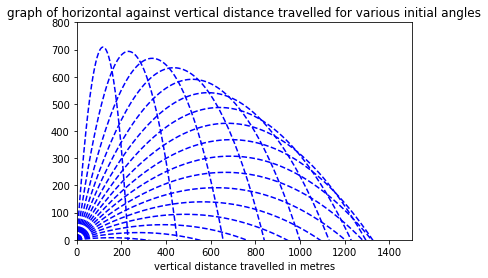

In [15]:
n_steps = 1000
thetas = range(5, 90, 5) # the angles in degrees
for j in thetas:
    initial_conditions = [0, 0, 125*numpy.cos(j*numpy.pi/180), 125*numpy.sin(j*numpy.pi/180)]
    values_euler = solve_euler(initial_conditions, 300, n_steps)
    xs_euler, ys_euler = values_euler[:,0], values_euler[:,1]
    plt.plot(xs_euler, ys_euler, color='blue', linestyle='--')
plt.xlim(0,1500)    
plt.ylim(0,800);
plt.xlabel('horizontal distance travelled in metres')
plt.xlabel('vertical distance travelled in metres')
plt.title('graph of horizontal against vertical distance travelled for various initial angles')

Create a plot to show the range for different values of the initial velocity. Use the same angle $\theta=60^\circ$ for all velocities. The plot should have axis labels and a title and legend. Produce one curve with and one curve without the effect of air resistance. [5 marks]


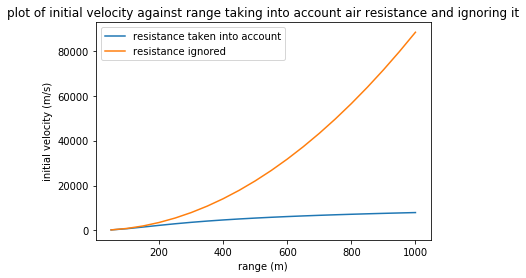

In [44]:
n_steps = 1000
max_time = 300
v0s = numpy.linspace(50, 1000, 20)

ranges = []
ranges_noresistance = []
theta = numpy.deg2rad(60)
for j in v0s:
    initial = (0,0,j*numpy.cos(theta),j*numpy.sin(theta))
    res = solve_euler(initial,max_time,n_steps)
    ranges.append(find_range(res))
    ranges_noresistance.append((j**2*numpy.sin(2*theta))/g)
plt.plot(v0s, ranges, label = 'resistance taken into account')    
plt.plot(v0s, ranges_noresistance, label = 'resistance ignored')
plt.xlabel('range (m)')
plt.ylabel('initial velocity (m/s)')
plt.title('plot of initial velocity against range taking into account air resistance and ignoring it')
plt.legend()
